# TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html?highlight=transfer%20learning

* Transfer learning
    * finetuning: 기존 모델에서 출발하여 현재 목적에 맞게 새로 학습
    * feature extraction: 기존 모델에서 마지막 레이어만들 학습, 기존 학습된 모델 부분을 feature extractor로 부른다.
    
전이 학습을 위해서는 다음 단계를 구현한다.

1. 기존 모델 준비
2. 새로운 목적에 부합하도록 마지막 몇 레이어를 대체한다.
3. 업데이트가 필요한 파라미터에 맞추어 최적화 방법을 설정한다.
4. 학습

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

import os
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
torch.__version__, torchvision.__version__

('1.5.0+cu101', '0.6.0+cu101')

In [2]:
data_path = Path(os.environ['HOME'])
data_path = data_path/'.torch/data/hymenoptera_data'

## Dataset

In [3]:
class HymenopteraDataset(object):
    def __init__(self, home: Path, train=True, transform=None):
        super().__init__()
        self.home = home
        self.images = list(home.glob('**/*.jpg'))
        self.transform = transform
        self.classes = {1: 'bees', 2: 'ants'}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path: Path = self.images[index]
        image = Image.open(image_path)
        
        label = image_path.parent.name
        label = 0 if label == 'bees' else 1
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
h = HymenopteraDataset(data_path/'train')
image, l = h[0]
image.height, image.width, l

(407, 500, 1)

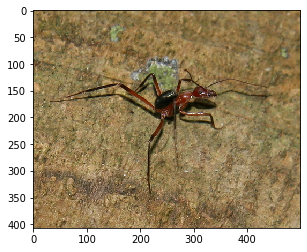

In [5]:
plt.imshow(np.array(image))

## Dataloaders

In [6]:
def get_data_loaders(train_batch_size, val_batch_size):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),  # [0, 255] -> [0.0, 1.0]
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    train_loader = torch.utils.data.DataLoader(
        HymenopteraDataset(data_path/'train', train=True, transform=data_transforms['train']),
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=4,
    )
    val_loader = torch.utils.data.DataLoader(
        HymenopteraDataset(data_path/'val', train=False, transform=data_transforms['val']),
        batch_size=val_batch_size,
        shuffle=False
    )
    return {'train': train_loader, 'val': val_loader}

### check data loaders

In [7]:
data_loaders = get_data_loaders(4, 1000)
inputs, labels = next(iter(data_loaders['train']))
labels

tensor([0, 1, 0, 1])

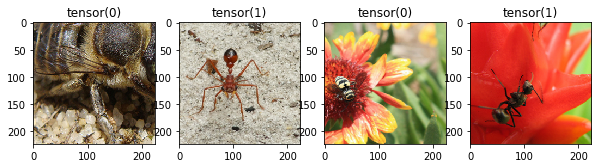

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

for j, (inp, lbl) in enumerate(zip(inputs, labels)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axs[j].imshow(inp)
    axs[j].set_title(lbl)

## Model: feature extractor

최종 fc 레이어를 bees/ants 또는 classes=2인 classifier로 변경한다. 모든 레이어의 파라미터를 동결하고 마지막 레이어를 추가한다.

In [9]:
model = models.resnet18(pretrained=True)

In [10]:
for param in model.fc.parameters():
    param.requires_grad = False

In [11]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [12]:
model.fc = nn.Linear(512, 2)

## Train

In [13]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import FastaiLRFinder
from ignite.contrib.handlers.tqdm_logger import ProgressBar
# from tqdm.notebook import tqdm

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_loaders = get_data_loaders(4, 100)

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 2)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)

In [16]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
ProgressBar(persist=False).attach(trainer, output_transform=lambda x: {'batch loss:': x})
lr_finder = FastaiLRFinder()
to_save = {'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.5) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(data_loaders['train'])
    
trainer.run(data_loaders['train'], max_epochs=10)

State:
	iteration: 610
	epoch: 10
	epoch_length: 61
	max_epochs: 10
	output: 0.4405171871185303
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

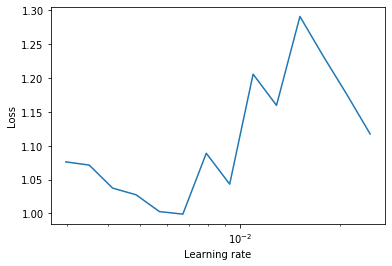

In [17]:
lr_finder.plot()

In [18]:
lr_finder.lr_suggestion()

0.01778939384940993

In [19]:
def run(train_batch_size, val_batch_size, epochs, lr, momentum, device):
    data_loaders = get_data_loaders(train_batch_size, val_batch_size)

    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)
    model.to(device)

#     criterion = nn.CrossEntropyLoss()
    criterion = lambda x, y: F.nll_loss(F.log_softmax(x, dim=0), y)

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    evaluator = create_supervised_evaluator(
        model,
        metrics={'acc': Accuracy(), 'loss': Loss(criterion)},
        device=device
    )
    
    pbar = ProgressBar(persist=True)
    pbar.attach(trainer, metric_names='all')
    
    @trainer.on(Events.EPOCH_COMPLETED)
    def log_results(engine):
        logs = dict()
        for dataset in ['train', 'val']:
            evaluator.run(data_loaders[dataset])
            metrics = evaluator.state.metrics
            pbar.log_message(f'Epoch {engine.state.epoch}, [{dataset}],'
                             f'\tacc={metrics["acc"]}  loss={metrics["loss"]}')
        pbar.n = pbar.last_print_n = 0
        
    trainer.run(data_loaders['train'], max_epochs=epochs)
    
    return model

In [20]:
model = run(4, 100, 10, 1e-2, 0.9, device)
model.to('cpu');


Epoch 1, [train],	acc=0.8353909465020576  loss=1.8967687325713076
Epoch 1, [val],	acc=0.8169934640522876  loss=6.713504753860772



Epoch 2, [train],	acc=0.49794238683127573  loss=3.3873862415674783
Epoch 2, [val],	acc=0.5424836601307189  loss=9.47656270569446



Epoch 3, [train],	acc=0.6995884773662552  loss=3.5346427915518177
Epoch 3, [val],	acc=0.7058823529411765  loss=10.969893517837026



Epoch 4, [train],	acc=0.5308641975308642  loss=4.155297450077387
Epoch 4, [val],	acc=0.47058823529411764  loss=11.775901588739133



Epoch 5, [train],	acc=0.7407407407407407  loss=3.5433778870743486
Epoch 5, [val],	acc=0.7320261437908496  loss=10.338133413028094



Epoch 6, [train],	acc=0.7983539094650206  loss=4.159910028363451
Epoch 6, [val],	acc=0.7843137254901961  loss=10.644450137817781



Epoch 7, [train],	acc=0.8641975308641975  loss=3.410992751396242
Epoch 7, [val],	acc=0.8496732026143791  loss=11.363903469509548



Epoch 8, [train],	acc=0.7530864197530864  loss=3.7687747672261525
Epoch 8, [val],	acc=0.803921568627451  loss=14.244013368693832



Epoch 9, [train],	acc=0.8106995884773662  loss=4.149745529080614
Epoch 9, [val],	acc=0.8627450980392157  loss=11.573280951556038



Epoch 10, [train],	acc=0.8888888888888888  loss=3.420019324179049
Epoch 10, [val],	acc=0.9019607843137255  loss=11.938746776456147


In [21]:
inputs, targets = next(iter(data_loaders['val']))
preds = model(inputs)
inputs = inputs[70:74]
targets = targets[70:74]
preds = preds[70:74]
_, indices = torch.max(F.softmax(preds, dim=1), 1)
targets, indices

(tensor([0, 0, 0, 0]), tensor([0, 0, 1, 0]))

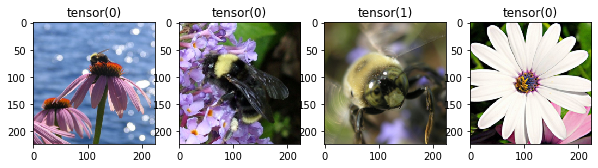

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

for j, (inp, lbl) in enumerate(zip(inputs, indices)):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axs[j].imshow(inp)
    axs[j].set_title(lbl)